# Projet 4 - Anticipez les besoins en consommation de bâtiments

# Prédiction de 'SiteEnergyUse(kBtu)'

## 1/ Chargement des packages

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.metrics import *
from sklearn.inspection import permutation_importance

## 2/ Téléchargement du jeu de données

In [14]:
data = pd.read_csv('C:/Users/raflg/Downloads/OpenClassrooms/Projet 4/2016_Building_Energy_Benchmarking_cleaned.csv')
data

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity,%_NaN,FirstPropertyUse,MacroPrimaryType,BuildingVolume,RatioGFAParking,BuildingAge
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,False,Compliant,249.98,2.83,0.0,Hotel,Hotel,1061208,0.000000,89
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,False,Compliant,295.86,2.86,0.0,Hotel,Hotel,988586,0.145453,20
2,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,False,Compliant,286.43,4.67,0.0,Hotel,Hotel,613200,0.000000,90
3,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,False,Compliant,505.01,2.88,0.0,Hotel,Hotel,2106440,0.353115,36
4,10,2016,NonResidential,Hotel,Camlin,1619 9th Avenue,Seattle,WA,98101.0,0660000825,...,False,Compliant,176.14,2.12,0.0,Hotel,Hotel,913088,0.000000,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061,50069,2016,NonResidential,Small- and Mid-Sized Office,Airport - Main Terminal,7277 Perimeter Rd.,Seattle,WA,98108.0,2824049007,...,False,Compliant,134.80,5.39,0.0,Office,Office,49980,0.000000,87
1062,50081,2016,SPS-District K-12,K-12 School,Hamlin Robinson School,1701 20th Ave South,Seattle,WA,98144.0,7548300840,...,False,Compliant,9.24,0.21,0.0,K-12 School,Education,135000,0.000000,1
1063,50210,2016,Nonresidential COS,Office,Central West HQ / Brown Bear,1403 w howe,Seattle,WA,NaN,2425039137,...,True,Error - Correct Default Data,3.50,0.26,0.0,Office,Office,13661,0.000000,64
1064,50220,2016,Nonresidential COS,Office,Genesee/SC SE HQ,4420 S Genesee,Seattle,WA,NaN,4154300585,...,True,Error - Correct Default Data,7.79,0.51,0.0,Office,Office,15398,0.000000,56


## 3/ Sélection des variables

In [15]:
data.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'DefaultData', 'ComplianceStatus', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', '%_NaN', 'FirstPropertyUse',
       'MacroPrimaryType', 'BuildingVolume', 'RatioGFAParking', 'BuildingAge'],
      dtype='object')

In [16]:
#Sélection des variables pour les estimateurs
var_sel = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'BuildingAge', 'NumberofFloors', 'PropertyGFATotal',
           'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 
           'ENERGYSTARScore', 'MacroPrimaryType', 'BuildingVolume', 'RatioGFAParking']

In [17]:
#Séparation du jeu de données avec la variable cible à estimer
X = data[var_sel]
y = data['SiteEnergyUse(kBtu)']

In [18]:
#Identification des variables catégorielles et numériques
cat_var = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'LargestPropertyUseType', 'MacroPrimaryType']
num_var = ['BuildingAge', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
           'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'BuildingVolume', 'RatioGFAParking']

In [19]:
data[num_var].describe()

,BuildingAge,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,BuildingVolume,RatioGFAParking
count,1066.000000,1066.000000,1.066000e+03,1066.000000,1.066000e+03,1.066000e+03,1066.000000,1.066000e+03,1066.000000
mean,52.771107,4.488743,1.095287e+05,13741.920263,9.578676e+04,9.027939e+04,65.507505,1.065682e+06,0.065783
std,31.778195,6.846566,1.578916e+05,41141.177807,1.324996e+05,1.214927e+05,28.459615,4.660959e+06,0.137753
min,1.000000,0.000000,1.229400e+04,0.000000,3.636000e+03,8.061000e+03,1.000000,0.000000e+00,0.000000
25%,28.000000,1.000000,3.178175e+04,0.000000,3.045975e+04,2.838500e+04,49.000000,5.044925e+04,0.000000
50%,49.000000,3.000000,5.258150e+04,0.000000,5.048150e+04,4.878600e+04,73.000000,1.155000e+05,0.000000
75%,78.000000,5.000000,1.158365e+05,0.000000,1.016478e+05,9.875275e+04,89.000000,4.037802e+05,0.000000
max,116.000000,99.000000,1.605578e+06,407795.000000,1.323055e+06,1.314475e+06,100.000000,6.847007e+07,0.895023


## 4/ Séparation du jeu de données (entrainement et test) et préparation des variables (encodage et standardisation)

In [20]:
#Création du KBinsDiscretizer pour stratifier les jeux d'entrainement et de test
KBD = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
stratify_ = KBD.fit_transform(np.array(y).reshape(-1, 1))

In [21]:
#Séparation des données en jeu de d'entrainement et jeu de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=stratify_, random_state=0)

In [22]:
#Création d'un transformer pour l'encodage et le scaling
transformer = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), cat_var),
                                      (StandardScaler(), num_var))

## 5/ Modèles d'estimation : création et recherches des meilleurs paramètres

In [23]:
#Création des modèles avec leurs paramètres
models = [
          {'name': 'Dummy Regressor', 'est': DummyRegressor()},
          {'name': 'Linear Regression', 'est': LinearRegression()}, 
          {'name': 'Lasso', 'est': Lasso(random_state=0)},
          {'name': 'Ridge', 'est': Ridge(random_state=0),
           'params': {'ridge__alpha': [25, 10, 4, 2, 1.0, 0.8, 0.5, 0.3, 0.2, 0.1, 0.05, 0.02, 0.01]}},
          {'name': 'Random Forest', 'est': RandomForestRegressor(random_state=0, n_estimators=200),
           'params': {'randomforestregressor__max_depth': range(15, 30)}},
          {'name': 'XGBoost', 'est': XGBRegressor(random_state=0, n_estimators=200),
           'params': {'xgbregressor__max_depth': range(2, 6), 
                      'xgbregressor__learning_rate': [1e-3, 1e-2, 1e-1], 
                      'xgbregressor__reg_alpha': np.linspace(1, 4, 16)}}
]

In [24]:
#Recherche des meilleurs paramètres
#Entrainement de l'estimateur avec les meilleurs paramètres
#Récolte des résultats (r2, MAE, RMSE)

models_details = []
stability_pred = {'y_test': np.array(y_test)}
for model in models:
    #Recherche des meilleurs paramètres et entrainement de l'estimateur
    if 'params' in model:
        est_pipeline = make_pipeline(transformer, model['est'])
        grid = GridSearchCV(est_pipeline, param_grid=model['params'], cv=5)
        grid.fit(X_train, y_train)
        
        best_params = grid.best_params_
        best_model = grid.best_estimator_
    else:
        best_model = make_pipeline(transformer, model['est'])
        best_model.fit(X_train, y_train)
        best_params = '-'
        
    #Prédiction du jeu test
    y_pred = best_model.predict(X_test)
    
    stability_pred['y_'+model['name']] = y_pred
    
    #Scores
    mae_ = mean_squared_error(y_test, y_pred)
    rmse_ = np.sqrt(mean_squared_error(y_test, y_pred))
    
    model_details = {'name': model['name'], 'train_r2': best_model.score(X_train, y_train), 
                     'test_r2': best_model.score(X_test, y_test), 'MAE': mae_, 'RMSE': rmse_, 'Params': best_params}
    models_details.append(model_details)

C:\Users\raflg\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1486073665748414.0, tolerance: 5460775647270.768
  model = cd_fast.sparse_enet_coordinate_descent(


## 6/ Interprétation des scores de performances des estimateurs

In [25]:
#Récupération des différents scores en dataframe
models_df = pd.DataFrame(models_details)
models_df = models_df.set_index('name')
models_df = models_df.sort_values(by=['test_r2'])
models_df = np.round(models_df, 2)

In [26]:
models_df

,train_r2,test_r2,MAE,RMSE,Params
name,,,,,
Dummy Regressor,0.00,-0.00,6.331005e+13,7956761.47,-
Ridge,0.81,0.80,1.272431e+13,3567114.92,{'ridge__alpha': 25}
Random Forest,0.98,0.82,1.134742e+13,3368593.57,{'randomforestregressor__max_depth': 18}
Linear Regression,0.84,0.83,1.046310e+13,3234672.15,-
Lasso,0.84,0.84,1.034164e+13,3215842.35,-
XGBoost,0.99,0.85,9.569361e+12,3093438.43,"{'xgbregressor__learning_rate': 0.1, 'xgbregre..."


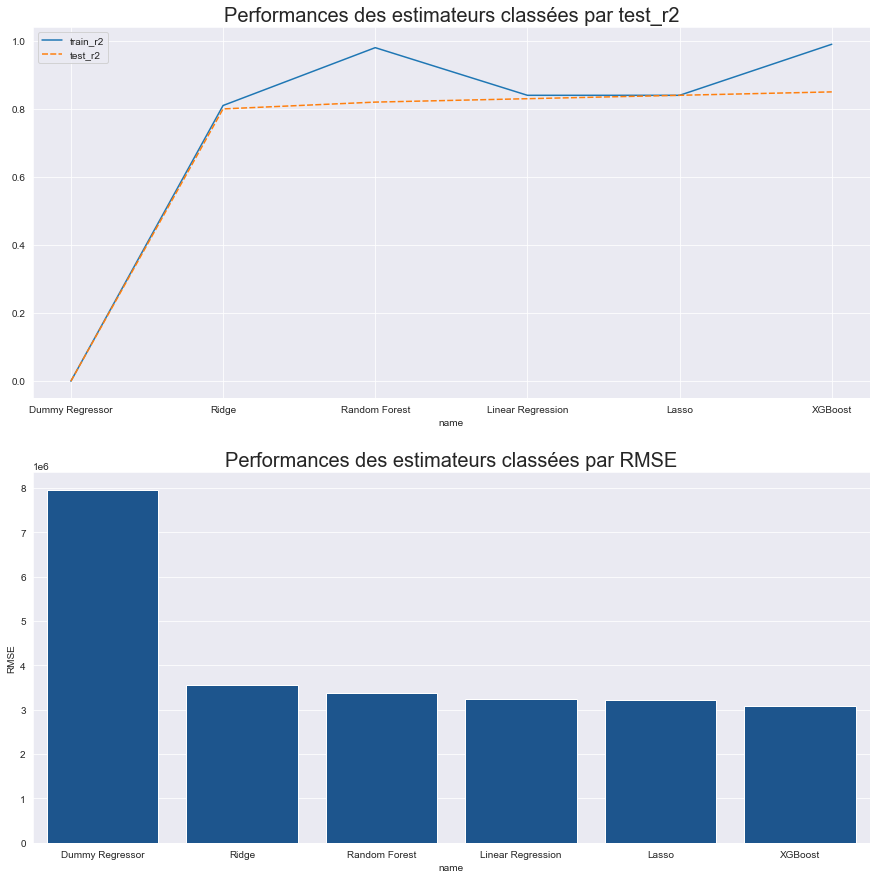

In [27]:
#Résumé et comparaison des scores d'évaluation des estimateurs
sns.set_style('darkgrid')
fig, axes = plt.subplots(2, 1, figsize=(15, 15))

sns.lineplot(ax=axes[0], data=models_df[['train_r2', 'test_r2']])
axes[0].set_title('Performances des estimateurs classées par test_r2', fontsize=20)

sns.barplot(ax=axes[1], data=models_df[['RMSE']].reset_index(), x='name', y='RMSE', color='#0b559f')
axes[1].set_title('Performances des estimateurs classées par RMSE', fontsize=20)

fig.savefig('C:/Users/raflg/Downloads/OpenClassrooms/Projet 4/est_perf_energy.png', bbox_inches='tight')
plt.show()

In [28]:
stab_df = pd.DataFrame(stability_pred)

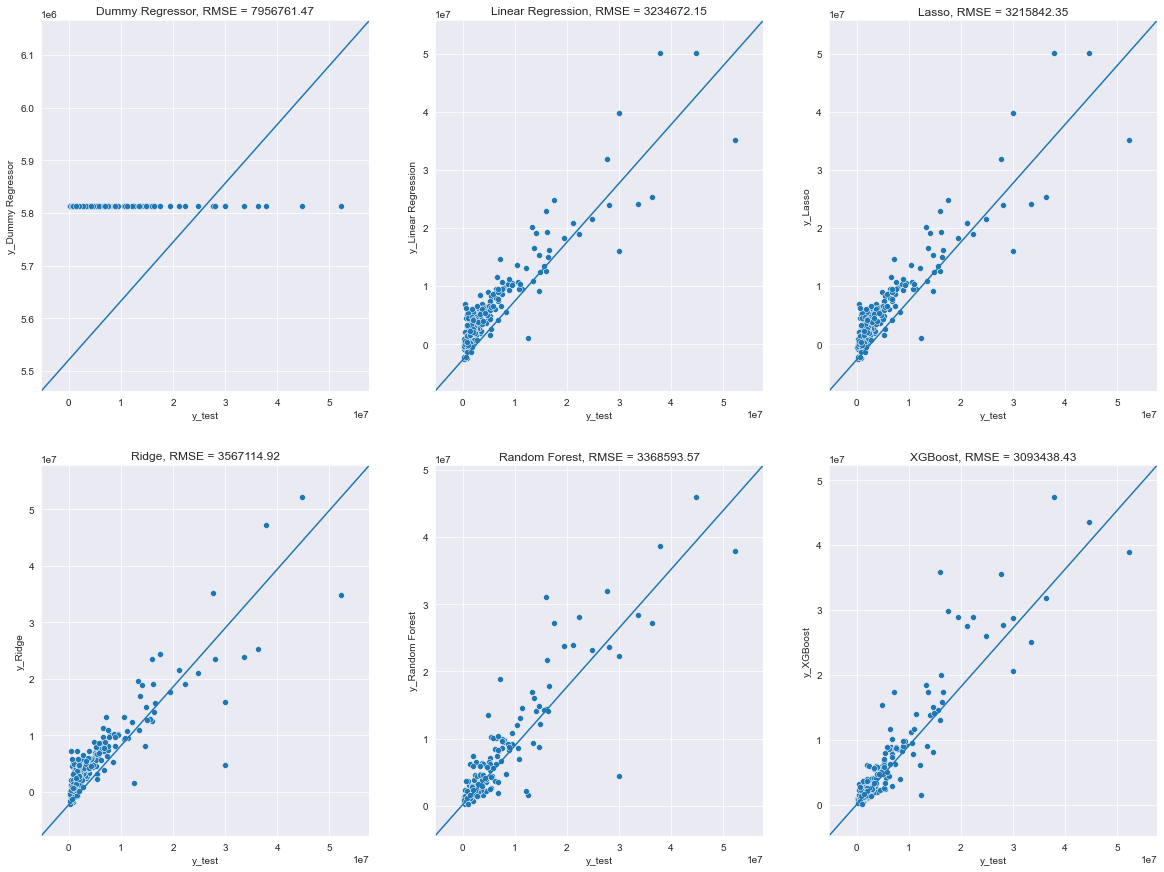

In [29]:
#Visualisation des écarts entre la variable à prédire et les prédictions
fig, axes = plt.subplots(2, 3, figsize=(20, 15))

sns.scatterplot(ax=axes[0, 0], data=stab_df, x='y_test', y='y_Dummy Regressor')
axes[0, 0].axline([axes[0, 0].get_xlim()[0], axes[0, 0].get_ylim()[0]], [axes[0, 0].get_xlim()[1], axes[0, 0].get_ylim()[1]])
axes[0, 0].set_title('Dummy Regressor, RMSE = {}'.format(models_df.at['Dummy Regressor', 'RMSE']))

sns.scatterplot(ax=axes[0, 1], data=stab_df, x='y_test', y='y_Linear Regression')
axes[0, 1].axline([axes[0, 1].get_xlim()[0], axes[0, 1].get_ylim()[0]], [axes[0, 1].get_xlim()[1], axes[0, 1].get_ylim()[1]])
axes[0, 1].set_title('Linear Regression, RMSE = {}'.format(models_df.at['Linear Regression', 'RMSE']))

sns.scatterplot(ax=axes[0, 2], data=stab_df, x='y_test', y='y_Lasso')
axes[0, 2].axline([axes[0, 2].get_xlim()[0], axes[0, 2].get_ylim()[0]], [axes[0, 2].get_xlim()[1], axes[0, 2].get_ylim()[1]])
axes[0, 2].set_title('Lasso, RMSE = {}'.format(models_df.at['Lasso', 'RMSE']))

sns.scatterplot(ax=axes[1, 0], data=stab_df, x='y_test', y='y_Ridge')
axes[1, 0].axline([axes[1, 0].get_xlim()[0], axes[1, 0].get_ylim()[0]], [axes[1, 0].get_xlim()[1], axes[1, 0].get_ylim()[1]])
axes[1, 0].set_title('Ridge, RMSE = {}'.format(models_df.at['Ridge', 'RMSE']))

sns.scatterplot(ax=axes[1, 1], data=stab_df, x='y_test', y='y_Random Forest')
axes[1, 1].axline([axes[1, 1].get_xlim()[0], axes[1, 1].get_ylim()[0]], [axes[1, 1].get_xlim()[1], axes[1, 1].get_ylim()[1]])
axes[1, 1].set_title('Random Forest, RMSE = {}'.format(models_df.at['Random Forest', 'RMSE']))

sns.scatterplot(ax=axes[1, 2], data=stab_df, x='y_test', y='y_XGBoost')
axes[1, 2].axline([axes[1, 2].get_xlim()[0], axes[1, 2].get_ylim()[0]], [axes[1, 2].get_xlim()[1], axes[1, 2].get_ylim()[1]])
axes[1, 2].set_title('XGBoost, RMSE = {}'.format(models_df.at['XGBoost', 'RMSE']))

fig.savefig('C:/Users/raflg/Downloads/OpenClassrooms/Projet 4/est_pred_stab_energy.png', bbox_inches='tight')
plt.show()

## 7/ Mesure de l'importance des variables pour le meilleur estimateur

- Intéressons nous à l'estimateur XGBoost

In [30]:
#Meilleurs paramètres du XGBoost
models_df.at['XGBoost', 'Params']

{'xgbregressor__learning_rate': 0.1,
 'xgbregressor__max_depth': 4,
 'xgbregressor__reg_alpha': 3.4000000000000004}

In [31]:
#Scores du XGBoost
models_df.loc['XGBoost', ['train_r2', 'test_r2', 'RMSE']]

train_r2          0.99
test_r2           0.85
RMSE        3093438.43
Name: XGBoost, dtype: object

In [37]:
#Création d'un fonction pour simplifier l'iteration de la tansformation log et choix des variables d'entrée
def xgb_reg(input_var, target, cat_var, num_var, log_var, log_num=True, log_target=True):
    '''
    Fonction permettant de réaliser la préparation des données, l'entrainement du modèle 
    et calcul des scores de performance
    @param input_var : liste des variables sélectionnées pour le modèle
    @param target : variable cible à prédire
    @param cat_var : list des variables catégorielles
    @param num_var : liste des variables numériques
    @param log_var : liste de variables à transformer avec log
    @param log_num : Bool pour procéder à la transformation log
    @param log_target : Bool pour procéder à la transformation log de la variable target
    '''
    X = data[input_var]
    y = data[target]
    
    if log_num:
        X = X.copy()
        X[log_var] = np.log1p(X[log_var])
    
    KBD = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    stratify_ = KBD.fit_transform(np.array(y).reshape(-1, 1))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=stratify_, random_state=0)
    
    transformer = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), cat_var),
                                          (StandardScaler(), num_var))
    
    model = make_pipeline(transformer, XGBRegressor(random_state=0, n_estimators=200, learning_rate=0.1,
                                                    max_depth=4, reg_alpha=3.4))
    
    if log_target:
        y_train_log = np.log1p(y_train)

        model.fit(X_train, y_train_log)

        y_train_pred = np.expm1(model.predict(X_train))
        y_test_pred = np.expm1(model.predict(X_test))

        print('R² train = '+ str(r2_score(y_train, y_train_pred))) 
        print('R² test = '+ str(r2_score(y_test, y_test_pred)))
        print('RMSE = '+ str(np.sqrt(mean_squared_error(y_test, y_test_pred))))
    
    else:
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        print('R² train = '+ str(model.score(X_train, y_train))) 
        print('R² test = '+ str(model.score(X_test, y_test)))
        print('RMSE = '+ str(np.sqrt(mean_squared_error(y_test, y_pred))))

In [39]:
#Entrainement du XGBoost avec les nouveaux paramètres en procédant à une transformation log sur la variable à prédire
log_var = ['NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
           'BuildingVolume', 'RatioGFAParking']

xgb_reg(var_sel, 'SiteEnergyUse(kBtu)', cat_var, num_var, log_var, log_num=False, log_target=True)

R² train = 0.8926056766893267
R² test = 0.7804081959692956
RMSE = 3727996.9861783166


In [41]:
#Entrainement du XGBoost avec les nouveaux paramètres en procédant à une transformation log sur la variable à prédire et les 
#variables d'entrée

xgb_reg(var_sel, 'SiteEnergyUse(kBtu)', cat_var, num_var, log_var, log_num=True, log_target=True)

R² train = 0.8926056766893267
R² test = 0.7804081959692956
RMSE = 3727996.9861783166


- Nous perdons 7% de précision sur le jeu test avec une perte de 10% sur le jeu d'entrainement pour un estimateur moins stable. Même constat en procédant à une transformation log sur les variables d'entrée

- Essayons avec une nouvelle sélection de variables d'entrée

In [46]:
var_sel_2 = ['BuildingType', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 
             'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'MacroPrimaryType', 'RatioGFAParking',
             'Latitude', 'Longitude']

cat_var_2 = ['BuildingType', 'LargestPropertyUseType', 'MacroPrimaryType']
num_var_2 = ['NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
             'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'Latitude', 'Longitude']
log_var_2 = ['NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
             'RatioGFAParking']

In [47]:
#Entrainement de l'estimateur sans transformation log
xgb_reg(var_sel_2, 'SiteEnergyUse(kBtu)', cat_var_2, num_var_2, log_var_2, log_num=False, log_target=False)

R² train = 0.9924020467025724
R² test = 0.8561164515870325
RMSE = 3017679.128593736


In [48]:
#Avec transformation log sur la variable à prédire
xgb_reg(var_sel_2, 'SiteEnergyUse(kBtu)', cat_var_2, num_var_2, log_var_2, log_num=False, log_target=True)

R² train = 0.8878204361517462
R² test = 0.7926410678200095
RMSE = 3622670.738325836


In [49]:
#Avec transformation log sur la variable à prédire et les variables d'entrée
xgb_reg(var_sel_2, 'SiteEnergyUse(kBtu)', cat_var_2, num_var_2, log_var_2, log_num=True, log_target=True)

R² train = 0.8878204361517462
R² test = 0.7926602023062257
RMSE = 3622503.5896484964


- Notre deuxième sélection de variable nous donne de meilleurs résultats. 
<br>Gain de 1% de précision sur le jeu test pour un estimateur plus stable

- Intéressons nous maintenant à l'importance des variables

In [51]:
X = data[var_sel_2]
y = data['SiteEnergyUse(kBtu)']

#Séparation des données en jeu de d'entrainement et jeu de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=stratify_, random_state=0)

#Création d'un transformer pour l'encodage et le scaling
transformer = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), cat_var_2),
                                      (StandardScaler(), num_var_2))

#Récupérons le meilleur estimateur
model = make_pipeline(transformer, XGBRegressor(random_state=0, n_estimators=200, learning_rate=0.1,
                                                max_depth=4, reg_alpha=3.4))

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

model.fit(X_train, y_train_log)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['BuildingType',
                                                   'LargestPropertyUseType',
                                                   'MacroPrimaryType']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'PropertyGFAParking',
                                                   'PropertyGFABuilding(s)',
                                                   'LargestPropertyUseTypeGFA',
                                                   'ENERGYSTARScore'...
          

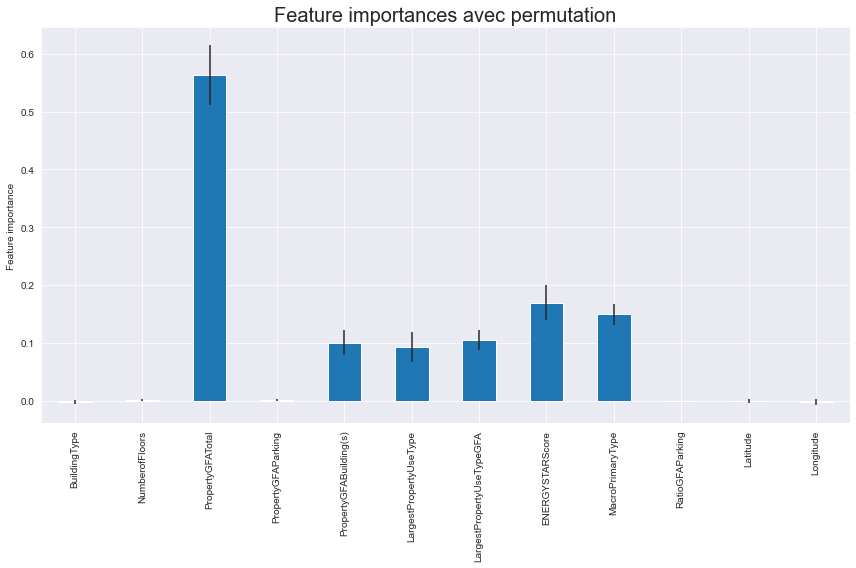

In [52]:
#Calcul de l'importance par permutation
result = permutation_importance(model, X_test, y_test_log, n_repeats=10, random_state=0, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

#Visualisation de l'importance des variables
fig, ax = plt.subplots(figsize=(12, 8))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title('Feature importances avec permutation', fontsize=20)
ax.set_ylabel('Feature importance')
fig.tight_layout()
fig.savefig('C:/Users/raflg/Downloads/OpenClassrooms/Projet 4/perm_imp_energy.png', bbox_inches='tight')
plt.show()

- La variable la plus importante est la surface totale du bâtiment. Nous pouvons regarder plus en détails l'importance de la variable MacroPrimaryType

In [55]:
#Importance des variables
features_imp = model.steps[1][1].feature_importances_
features_name = model[0].get_feature_names_out()

features_imp_df = pd.DataFrame(np.array([features_name, features_imp]).T, columns=['Features', 'Feature importance'])
features_imp_df['Feature importance'] = features_imp_df['Feature importance'].astype('float')

features_imp_macro = features_imp_df[features_imp_df['Features'].str.contains('Macro')].copy()

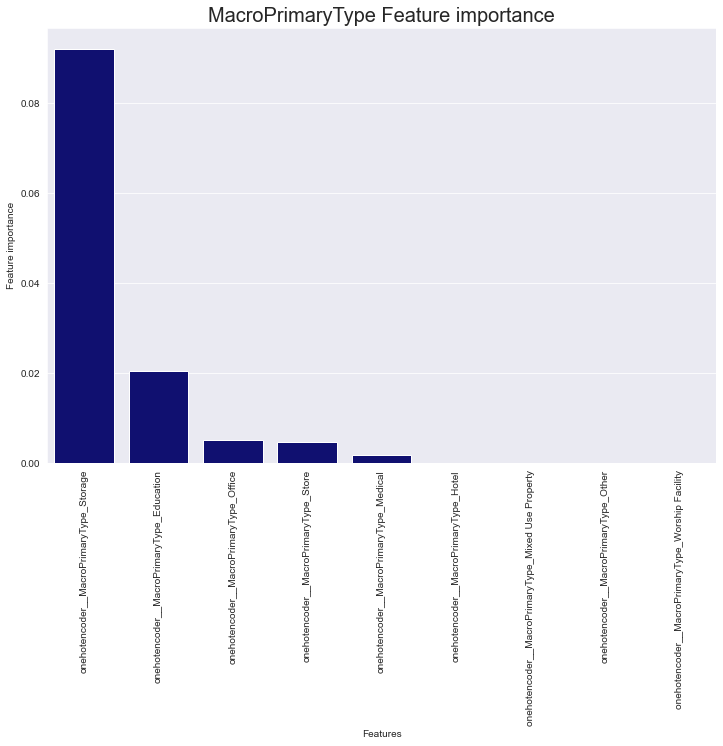

In [56]:
#Visualisation de l'importance du MacroPrimaryType
plt.figure(figsize=(12, 8))
sns.barplot(data=features_imp_macro.sort_values(by='Feature importance', ascending=False), 
            x='Features', y='Feature importance',
            color='navy')
plt.xticks(rotation=90)
plt.title('MacroPrimaryType Feature importance', fontsize=20)
plt.savefig('C:/Users/raflg/Downloads/OpenClassrooms/Projet 4/feature_imp_energy_macro.png', bbox_inches='tight')
plt.show()